In [1]:
import torch
import numpy as np
import pandas as pd
import DNN_utils as utils
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.linear_model import LinearRegression
from datetime import datetime
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
# IF EXECUTING ON COLLAB UNCOMMENT THIS CELL

#import os
#from google.colab import drive
#drive.mount('/content/gdrive')
#folder = '/content/gdrive/My Drive/Data ML Project'
#os.chdir(folder)
#print(torch.cuda.is_available())

# Set these right after importing torch, before any other operations
torch.set_num_threads(os.cpu_count())
torch.set_num_interop_threads(os.cpu_count())


In [3]:
daily = pd.read_csv("Targets/daily_crsp_sanitized.csv", nrows = 2000000)
daily['date'] = pd.to_datetime(daily['date'], format = "%Y-%m-%d")
daily = daily[daily['date'] >= '2000-01-31'] # Start at the end of January to align with predictors data
daily

,date,PERMCO,PERMNO,SICCD,NAICS,DlyRet,sprtrn
158482,2000-01-31,5,15580,6320,0,-0.068182,0.025218
158483,2000-01-31,7,14593,3573,0,0.020910,0.025218
158484,2000-01-31,25,62770,6711,0,0.041045,0.025218
158485,2000-01-31,29,59184,2082,0,0.011236,0.025218
158486,2000-01-31,33,59248,2082,0,0.034667,0.025218
...,...,...,...,...,...,...,...
1999995,2000-12-13,16265,86321,6310,0,0.057471,-0.008161
1999996,2000-12-13,16266,86324,7370,0,-0.063291,-0.008161
1999997,2000-12-13,16267,86337,3660,0,-0.101449,-0.008161
1999998,2000-12-13,16268,86339,4899,0,0.009456,-0.008161


In [4]:
# Remove outliers
# Compute quantile thresholds for winsorization
lower_quantile = daily['DlyRet'].quantile(0.005)
upper_quantile = daily['DlyRet'].quantile(0.995)


# Identify outliers for reporting
outliers = (daily['DlyRet'] < lower_quantile) | (daily['DlyRet'] > upper_quantile)
print(f"Number of daily return outliers: {outliers.sum():,}")

# Winsorize: cap values at the quantile thresholds
daily['DlyRet'] = daily['DlyRet'].clip(lower=lower_quantile, upper=upper_quantile)
daily.describe()

Number of daily return outliers: 18,415


,date,PERMCO,PERMNO,SICCD,NAICS,DlyRet,sprtrn
count,1841518,1.841518e+06,1.841518e+06,1.841518e+06,1841518.0,1.841518e+06,1.841518e+06
mean,2000-07-06 21:08:56.728068480,1.738957e+04,7.050770e+04,5.110886e+03,0.0,-4.055828e-04,1.124562e-04
min,2000-01-31 00:00:00,5.000000e+00,1.000100e+04,0.000000e+00,0.0,-1.907121e-01,-5.827800e-02
25%,2000-04-18 00:00:00,1.129900e+04,6.839800e+04,3.621000e+03,0.0,-2.142900e-02,-8.207000e-03
50%,2000-07-07 00:00:00,1.562500e+04,8.027600e+04,5.149000e+03,0.0,0.000000e+00,-2.280000e-04
75%,2000-09-25 00:00:00,2.167800e+04,8.540500e+04,6.726000e+03,0.0,1.718200e-02,8.130000e-03
max,2000-12-13 00:00:00,5.701800e+04,9.331600e+04,9.990000e+03,0.0,2.490120e-01,4.763900e-02
std,NaN,9.527787e+03,2.312819e+04,1.916887e+03,0.0,5.304362e-02,1.372986e-02


In [9]:
# Step 1: Create lagged S&P 500 return series by date
sp500_lagged = daily[['date', 'sprtrn']].drop_duplicates().sort_values('date')
sp500_lagged['sprtrn_lag1'] = sp500_lagged['sprtrn'].shift(1).fillna(0.0)
#sp500_lagged
# Step 2: Merge lagged S&P 500 return back into main DataFrame
daily = daily.merge(sp500_lagged[['date', 'sprtrn_lag1']], on='date', how='left')
daily

,date,PERMCO,PERMNO,SICCD,NAICS,DlyRet,sprtrn,sprtrn_lag1_x,sprtrn_lag1_y,sprtrn_lag1
0,2000-01-31,5,15580,6320,0,-0.068182,0.025218,0.000000,0.000000,0.000000
1,2000-01-31,7,14593,3573,0,0.020910,0.025218,0.000000,0.000000,0.000000
2,2000-01-31,25,62770,6711,0,0.041045,0.025218,0.000000,0.000000,0.000000
3,2000-01-31,29,59184,2082,0,0.011236,0.025218,0.000000,0.000000,0.000000
4,2000-01-31,33,59248,2082,0,0.034667,0.025218,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
1841513,2000-12-13,16265,86321,6310,0,0.057471,-0.008161,-0.006535,-0.006535,-0.006535
1841514,2000-12-13,16266,86324,7370,0,-0.063291,-0.008161,-0.006535,-0.006535,-0.006535
1841515,2000-12-13,16267,86337,3660,0,-0.101449,-0.008161,-0.006535,-0.006535,-0.006535
1841516,2000-12-13,16268,86339,4899,0,0.009456,-0.008161,-0.006535,-0.006535,-0.006535


In [5]:
# Get data frame of unique months
daily['year_month'] = daily['date'].dt.to_period('M')
unique_months = daily['year_month'].drop_duplicates().sort_values()
unique_months

158482     2000-01
166811     2000-02
333239     2000-03
524367     2000-04
682344     2000-05
865365     2000-06
1048421    2000-07
1214853    2000-08
1407308    2000-09
1573891    2000-10
1756726    2000-11
1930059    2000-12
Name: year_month, dtype: period[M]

In [6]:
def softmax(x):
    e_x = np.exp(x - np.max(x))  # for numerical stability
    return e_x / e_x.sum()

In [7]:
# Keeping track of the return over all the data
all_strategy_returns = []

for i in range(0, len(unique_months) - 6 - 1):

    # Train on 6 months of data and test on 1 month
    train_start = unique_months.iloc[i]
    train_end = unique_months.iloc[i+6]
    test_month = unique_months.iloc[i+7]

    print(f'Training from {train_start} to {train_end}. Testing on {test_month}.')
    
    # Filter data
    train_mask = (daily['year_month'] >= train_start) & (daily['year_month'] <= train_end)
    test_mask = daily['year_month'] == test_month

    tr_df = daily[train_mask].copy()
    te_df = daily[test_mask].copy()

    # Prepare the data: construct lagged returns, rolling window averages
    train_df, test_df, features, cat_features = utils.prepare_data(tr_df, te_df, lagged_num=1, rolling_window=True)

    #print(test_df.shape)
    
    train_losses, test_losses, train_sharpes, test_sharpes, raw_predictions = utils.train_DNN(train_df, test_df, features, cat_features, epochs=5)

    #print(strat_returns.shape)
    # Right after getting strat_returns
    #print(f"strat_returns stats: min={strat_returns.min()}, max={strat_returns.max()}, nan_count={strat_returns.isna().sum()}")
    #print(f"strat_returns shape: {strat_returns.shape}")
    #print(f"test_df shape: {test_df.shape}")

    # Add strat_returns as a new column to test_df
    #test_df['strat_return'] = strat_returns 

    # After assigning to test_df

    test_df['raw_predictions'] = raw_predictions.values 
    test_df['weight'] = test_df.groupby('date')['raw_predictions'].transform(softmax)

    test_df['strategy_return'] = test_df['weight'] * test_df['DlyRet']
    
    #test_df['strat_return'] = strat_returns.values 
    #print(f"test_df['strat_return'] nan_count: {test_df['strat_return'].isna().sum()}")

    # Calculate mean returns by date
    mean_daily_returns = test_df.groupby('date')['strategy_return'].sum()

    # Check if the groupby operation is the issue
    #mean_daily_returns = test_df.groupby('date')['strat_return'].mean()
    #print(f"mean_daily_returns nan_count: {mean_daily_returns.isna().sum()}")
    
    #print(mean_daily_returns.shape)
    all_strategy_returns.append(mean_daily_returns)








# Concatenate all windows into one Series
combined_returns = pd.concat(all_strategy_returns)



Training from 2000-01 to 2000-07. Testing on 2000-08.
['sprtrn', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 516 train batches, 47 test batches


Training:  20%|███████                            | 1/5 [00:16<01:06, 16.67s/it]

Epoch 1/5, Loss: -0.0092, Train Sharpe: 0.0204, Test Sharpe: 0.0450


Training:  60%|█████████████████████              | 3/5 [00:50<00:33, 16.83s/it]

Epoch 3/5, Loss: -0.0447, Train Sharpe: 0.0509, Test Sharpe: 0.0544


Training: 100%|███████████████████████████████████| 5/5 [01:22<00:00, 16.58s/it]

Epoch 5/5, Loss: -0.0593, Train Sharpe: 0.0612, Test Sharpe: 0.0581
Training completed! Best test Sharpe ratio: 0.0581
Training from 2000-02 to 2000-08. Testing on 2000-09.


['sprtrn', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 606 train batches, 41 test batches


Training:  20%|███████                            | 1/5 [00:18<01:15, 18.85s/it]

Epoch 1/5, Loss: -0.0154, Train Sharpe: 0.0356, Test Sharpe: 0.0254


Training:  60%|█████████████████████              | 3/5 [00:56<00:37, 18.89s/it]

Epoch 3/5, Loss: -0.0580, Train Sharpe: 0.0577, Test Sharpe: 0.0469


Training: 100%|███████████████████████████████████| 5/5 [01:37<00:00, 19.41s/it]

Epoch 5/5, Loss: -0.0677, Train Sharpe: 0.0666, Test Sharpe: 0.0483
Training completed! Best test Sharpe ratio: 0.0483
Training from 2000-03 to 2000-09. Testing on 2000-10.


['sprtrn', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 606 train batches, 45 test batches


Training:  20%|███████                            | 1/5 [00:19<01:16, 19.07s/it]

Epoch 1/5, Loss: -0.0105, Train Sharpe: 0.0570, Test Sharpe: 0.0727


Training:  60%|█████████████████████              | 3/5 [00:57<00:38, 19.07s/it]

Epoch 3/5, Loss: -0.0605, Train Sharpe: 0.0764, Test Sharpe: 0.0913


Training: 100%|███████████████████████████████████| 5/5 [01:35<00:00, 19.14s/it]

Epoch 5/5, Loss: -0.0683, Train Sharpe: 0.0876, Test Sharpe: 0.0990
Training completed! Best test Sharpe ratio: 0.0990
Training from 2000-04 to 2000-10. Testing on 2000-11.


['sprtrn', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 602 train batches, 43 test batches


Training:  20%|███████                            | 1/5 [00:18<01:14, 18.73s/it]

Epoch 1/5, Loss: -0.0240, Train Sharpe: 0.0696, Test Sharpe: 0.0917


Training:  60%|█████████████████████              | 3/5 [00:57<00:38, 19.04s/it]

Epoch 3/5, Loss: -0.0710, Train Sharpe: 0.0851, Test Sharpe: 0.1046


Training: 100%|███████████████████████████████████| 5/5 [01:35<00:00, 19.01s/it]

Epoch 5/5, Loss: -0.0762, Train Sharpe: 0.0902, Test Sharpe: 0.1069
Training completed! Best test Sharpe ratio: 0.1070
Training from 2000-05 to 2000-11. Testing on 2000-12.


['sprtrn', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 610 train batches, 18 test batches


Training:  20%|███████                            | 1/5 [00:19<01:16, 19.03s/it]

Epoch 1/5, Loss: -0.0226, Train Sharpe: 0.0541, Test Sharpe: 0.0059


Training:  60%|█████████████████████              | 3/5 [00:55<00:37, 18.51s/it]

Epoch 3/5, Loss: -0.0762, Train Sharpe: 0.0740, Test Sharpe: 0.0339


Training: 100%|███████████████████████████████████| 5/5 [01:32<00:00, 18.53s/it]

Epoch 5/5, Loss: -0.0841, Train Sharpe: 0.0818, Test Sharpe: 0.0402
Training completed! Best test Sharpe ratio: 0.0402


<Axes: title={'center': 'Cumulative Strategy Returns'}, xlabel='date'>

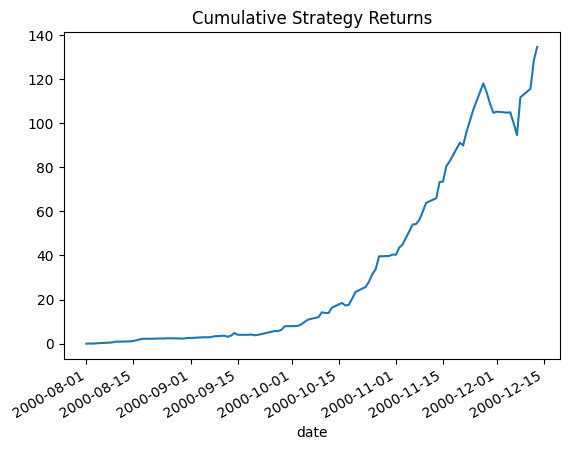

In [8]:
combined_returns = combined_returns.sort_index()

# Convert to DataFrame and calculate cumulative returns
results_df = pd.DataFrame({
    'daily_return': combined_returns,
    'cumulative_return': (1 + combined_returns).cumprod() - 1  # Geometric compounding
})

# Now you can plot:
results_df['cumulative_return'].plot(title='Cumulative Strategy Returns')

In [9]:
combined_returns

date
2000-08-01   -0.013437
2000-08-02    0.086483
2000-08-03   -0.035922
2000-08-04    0.126855
2000-08-07    0.206109
                ...   
2000-12-07   -0.053528
2000-12-08    0.179131
2000-12-11    0.034629
2000-12-12    0.110182
2000-12-13    0.047174
Name: strategy_return, Length: 95, dtype: float64

<Axes: title={'center': 'Cumulative Strategy Returns'}, xlabel='date'>

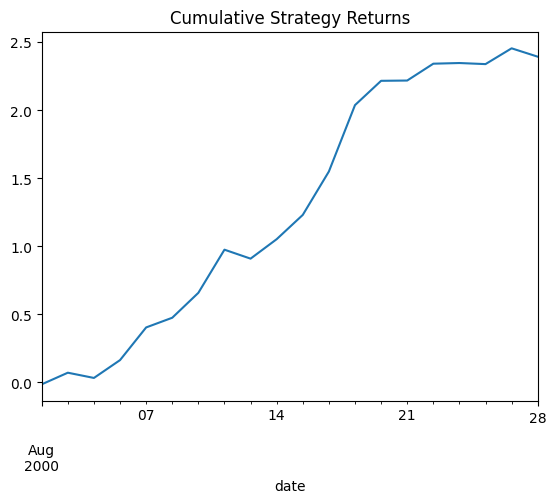

In [10]:
results_df['cumulative_return'].iloc[0:20].plot(title='Cumulative Strategy Returns')

In [11]:
sharpe = np.sqrt(95) * (combined_returns.mean() / mean_daily_returns.std())
sharpe

np.float64(7.2866841729047085)

In [14]:
max_row = daily.loc[daily['DlyRet'].idxmax()]
max_row

date          2000-03-06 00:00:00
PERMCO                      13537
PERMNO                      81283
SICCD                        3570
NAICS                           0
DlyRet                   4.045455
sprtrn                  -0.012695
year_month                2000-03
Name: 361324, dtype: object

In [5]:
index_df = pd.read_csv('Predictors/FirmCharacIndex.csv')
index_df

,Unnamed: 0,date,PERMNO,gvkey,pls_index
0,0,2000-01-31,10025,11903,-3.107469
1,1,2000-01-31,10089,12143,-1.304217
2,2,2000-01-31,10155,12094,-2.892794
3,3,2000-01-31,10182,12171,5.863377
4,4,2000-01-31,10256,12226,-3.608628
...,...,...,...,...,...
520167,520167,2024-12-31,93426,185138,-0.052260
520168,520168,2024-12-31,93427,179583,3.371618
520169,520169,2024-12-31,93429,184500,5.908846
520170,520170,2024-12-31,93434,184259,-4.831854


In [6]:
merged = utils.merge_pls_with_asof(daily, index_df)
merged = merged.fillna(0)
merged

Processing 7762 common PERMNOs...
Processing PERMNO 1/7762
Processing PERMNO 1001/7762
Processing PERMNO 2001/7762
Processing PERMNO 3001/7762
Processing PERMNO 4001/7762
Processing PERMNO 5001/7762
Processing PERMNO 6001/7762
Processing PERMNO 7001/7762
Adding 1242 PERMNOs without PLS data...
Combining results...


,date,PERMCO,PERMNO,SICCD,NAICS,DlyRet,sprtrn,year_month,pls_index
0,2000-01-31,7953,10001,4920,0,-0.029851,0.025218,2000-01,0.000000
1,2000-01-31,7954,10002,6020,0,-0.005236,0.025218,2000-01,0.000000
2,2000-01-31,7965,10009,6030,0,-0.004255,0.025218,2000-01,0.000000
3,2000-01-31,7969,10012,3670,0,-0.033333,0.025218,2000-01,0.000000
4,2000-01-31,1728,10016,3560,0,0.038168,0.025218,2000-01,0.000000
...,...,...,...,...,...,...,...,...,...
1441513,2000-10-05,7428,92690,6798,0,-0.006711,0.001367,2000-10,0.710286
1441514,2000-10-05,7407,92807,6020,0,0.000000,0.001367,2000-10,0.117273
1441515,2000-10-05,7378,92874,3690,0,-0.059701,0.001367,2000-10,-0.907260
1441516,2000-10-05,7323,92930,3714,0,-0.011321,0.001367,2000-10,4.626466


In [7]:
# Keeping track of the return over all the data
all_raw_predictions = []

for i in range(0, len(unique_months) - 6 - 1):

    # Train on 6 months of data and test on 1 month
    train_start = unique_months.iloc[i]
    train_end = unique_months.iloc[i+6]
    test_month = unique_months.iloc[i+7]

    print(f'Training from {train_start} to {train_end}. Testing on {test_month}.')
    
    # Filter data
    train_mask = (merged['year_month'] >= train_start) & (merged['year_month'] <= train_end)
    test_mask = merged['year_month'] == test_month

    tr_df = merged[train_mask].copy()
    te_df = merged[test_mask].copy()

    # Prepare the data: construct lagged returns, rolling window averages
    train_df, test_df, features, cat_features = utils.prepare_data(tr_df, te_df, lagged_num=1, rolling_window=True)

    #print(test_df.shape)
    
    train_losses, test_losses, train_sharpes, test_sharpes, raw_predictions = utils.train_DNN(train_df, test_df, features, cat_features, epochs=4)

    #print(strat_returns.shape)
    # Right after getting strat_returns
    #print(f"strat_returns stats: min={strat_returns.min()}, max={strat_returns.max()}, nan_count={strat_returns.isna().sum()}")
    #print(f"strat_returns shape: {strat_returns.shape}")
    #print(f"test_df shape: {test_df.shape}")

    # Add strat_returns as a new column to test_df
    #test_df['strat_return'] = strat_returns 

    # After assigning to test_df
    test_df['strat_return'] = strat_returns.values 
    #print(f"test_df['strat_return'] nan_count: {test_df['strat_return'].isna().sum()}")

    # Calculate mean returns by date
    mean_daily_returns = test_df.groupby('date')['strat_return'].mean()

    # Check if the groupby operation is the issue
    #mean_daily_returns = test_df.groupby('date')['strat_return'].mean()
    #print(f"mean_daily_returns nan_count: {mean_daily_returns.isna().sum()}")
    
    #print(mean_daily_returns.shape)
    all_strategy_returns.append(mean_daily_returns)






# Concatenate all windows into one Series
combined_returns = pd.concat(all_strategy_returns)



Training from 2000-01 to 2000-07. Testing on 2000-08.
['DlyRet', 'sprtrn', 'pls_index', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 516 train batches, 47 test batches


Training:  25%|████████▊                          | 1/4 [00:17<00:51, 17.09s/it]

Epoch 1/4, Loss: -0.6767, Train Sharpe: 1.3908, Test Sharpe: 1.2096


Training:  75%|██████████████████████████▎        | 3/4 [00:54<00:18, 18.29s/it]

Epoch 3/4, Loss: -1.3135, Train Sharpe: 1.6550, Test Sharpe: 1.4923


Training: 100%|███████████████████████████████████| 4/4 [01:10<00:00, 17.58s/it]

Epoch 4/4, Loss: -1.3689, Train Sharpe: 1.6328, Test Sharpe: 1.4852
Training completed! Best test Sharpe ratio: 1.4923


NameError: name 'strat_returns' is not defined

In [ ]:
combined_returns

In [8]:
# Handle duplicate dates (if any) by taking the mean
#combined_returns = combined_returns.groupby(level=0).mean()

# Sort by date to ensure chronological order
combined_returns = combined_returns.sort_index()

# Convert to DataFrame and calculate cumulative returns
results_df = pd.DataFrame({
    'daily_return': combined_returns,
    'cumulative_return': (1 + combined_returns).cumprod() - 1  # Geometric compounding
})

# Now you can plot:
results_df['cumulative_return'].plot(title='Cumulative Strategy Returns')

NameError: name 'combined_returns' is not defined